Train the model on all numbers except for 7 and then test with the 7s

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-1-a8aed9fadacf>:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [10]:
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')
labels = data[:,0]
data   = data[:,1:]
dataNorm = data / np.max(data)

# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long() # long = int64
the7s = np.where(labels == 7)
everythingElse = np.where(labels!= 7)

In [85]:
temp_train_data= torch.tensor(dataNorm[[everythingElse[0]]][0]).float()
temp_test_data = torch.tensor(dataNorm[[the7s[0]]][0]).float()
temp_train_labels = torch.tensor(labels[[everythingElse[0]]][0]).long()
temp_test_labels = torch.tensor(labels[[the7s[0]]][0]).long()


In [86]:
# Step 2: use scikitlearn to split the data


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(temp_train_data,temp_train_labels)
test_data  = TensorDataset(temp_test_data,temp_test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [45]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)

      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)
      # NEW HERE: log-softmax the output, because I'm using NLLLoss instead of CrossEntropyLoss

  # create the model instance
  net = mnistNet()

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optifun = getattr(torch.optim, 'SGD')
  optimizer = optifun(net.parameters(),lr=0.01)

  return net,lossfun,optimizer

In [51]:
# a function that trains the model

def funtion2trainTheModel():

  # number of epochs
  numepochs = 500

  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses   = torch.zeros(2,numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...







    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[0,epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
    losses[1,epochi] = lossfun(yHat,y).item()
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


In [52]:
trainAcc,testAcc,losses,net = funtion2trainTheModel()

In [53]:
X,y = next(iter(test_loader))
predictions = net(X).detach()

torch.exp(predictions)

tensor([[1.1229e+07, 1.9360e-10, 6.0227e-04,  ..., 1.0700e-07, 1.3093e+00,
         7.2021e+07],
        [7.8249e+01, 6.6030e-05, 1.1530e+04,  ..., 3.6952e-08, 6.1049e+01,
         8.2159e+09],
        [1.8644e-02, 4.3728e+00, 2.3136e+05,  ..., 5.5551e-09, 2.7222e+03,
         1.3701e+11],
        ...,
        [1.2810e+01, 5.3849e+00, 4.0047e+07,  ..., 1.3887e-05, 9.6210e-02,
         4.8052e+04],
        [2.9908e-02, 1.1578e+01, 5.3490e-02,  ..., 8.0966e-06, 1.3975e+02,
         3.2029e+09],
        [5.7970e-04, 7.9733e+02, 2.0591e+01,  ..., 1.4105e-05, 2.4779e+04,
         7.5582e+05]])

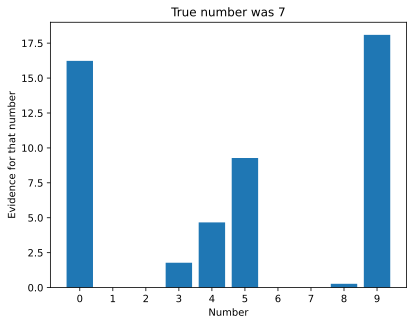

In [125]:
# Evidence for all numbers from one sample
sample2show = 120

plt.bar(range(10),torch.exp(torch.log(predictions[0]))) # try adding exp!
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title('True number was %s' %y[0].item())
plt.show()

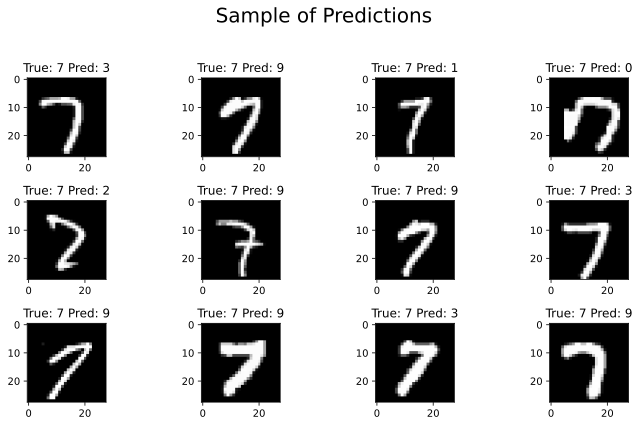

In [105]:
np.random.seed(2)
# show a few random digits
fig,axs = plt.subplots(3,4,figsize=(10,6))

for ax in axs.flatten():
  # pick a random image
  randimg2show = np.random.randint(0,high=temp_test_data.shape[0])

  # create the image (must be reshaped!)
  img = np.reshape(temp_test_data[randimg2show,:],(28,28))
  ax.imshow(img,cmap='gray')

  # title
  ax.set_title(f'True: {temp_test_labels[randimg2show].item()} Pred: {np.argmax(predictions[randimg2show]).item()}')

plt.suptitle('Sample of Predictions',fontsize=20)
plt.tight_layout(rect=[0,0,1,.95])
plt.show()

## Accuracy and Loss

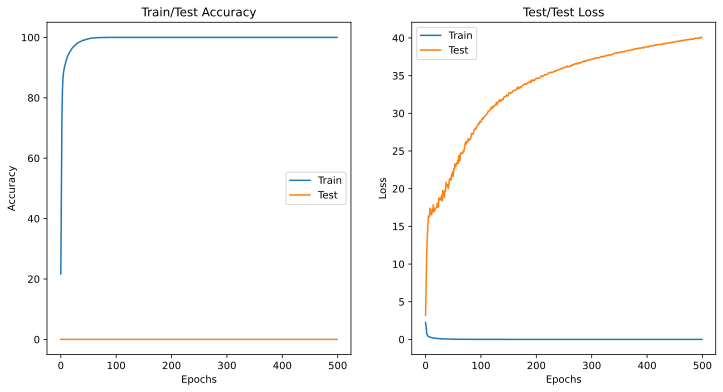

In [111]:
# show accuracy as a function of model depth
fig,ax = plt.subplots(1,2,figsize=(12,6))
epochs = range(500)

ax[0].plot(epochs, trainAcc,markerfacecolor='w',markersize=9)
ax[0].plot(epochs, testAcc,markerfacecolor='r',markersize=9)
# ax[0].plot(numunits[[0,-1]],[33,33],'--',color=[.8,.8,.8])
# ax[0].plot(numunits[[0,-1]],[67,67],'--',color=[.8,.8,.8])
ax[0].legend(['Train', "Test"])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Train/Test Accuracy')

ax[1].plot(epochs, losses[0],markerfacecolor='w',markersize=9)
ax[1].plot(epochs, losses[1],markerfacecolor='w',markersize=9)

# ax[1].plot(numunits[[0,-1]],[33,33],'--',color=[.8,.8,.8])
# ax[1].plot(numunits[[0,-1]],[67,67],'--',color=[.8,.8,.8])
ax[1].legend(['Train', "Test"])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_title('Test/Test Loss')
plt.show()

##Distribution of most common guess

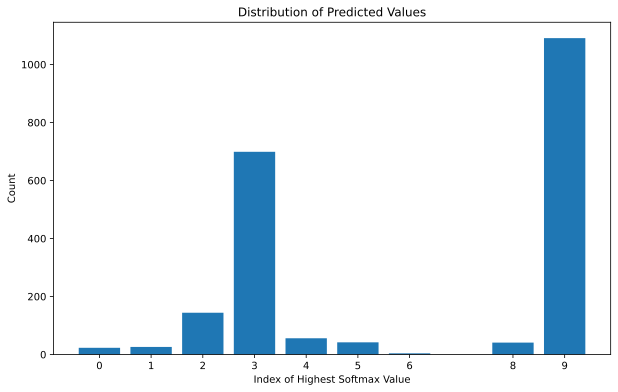

In [120]:
max_indices = torch.argmax(predictions, dim=1).numpy()

# Count the occurrences of each index
unique, counts = np.unique(max_indices, return_counts=True)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(unique, counts, tick_label=unique)
plt.xlabel('Index of Highest Softmax Value')
plt.ylabel('Count')
plt.title('Distribution of Predicted Values')
plt.show()